In [2]:
import cv2
original_img = cv2.imread('media/images/books/Novels.jpg') 

def detector(novel):

    status = None
    result = original_img.copy()
    img1 = cv2.cvtColor(novel, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

    
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10


    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        result = cv2.polylines(result,[np.int32(dst)],True,(0,255,50),15)
    else:
        status = "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT)
        matchesMask = None
        result = np.zeros_like(original_img, dtype=np.int8)
    
    return status, result


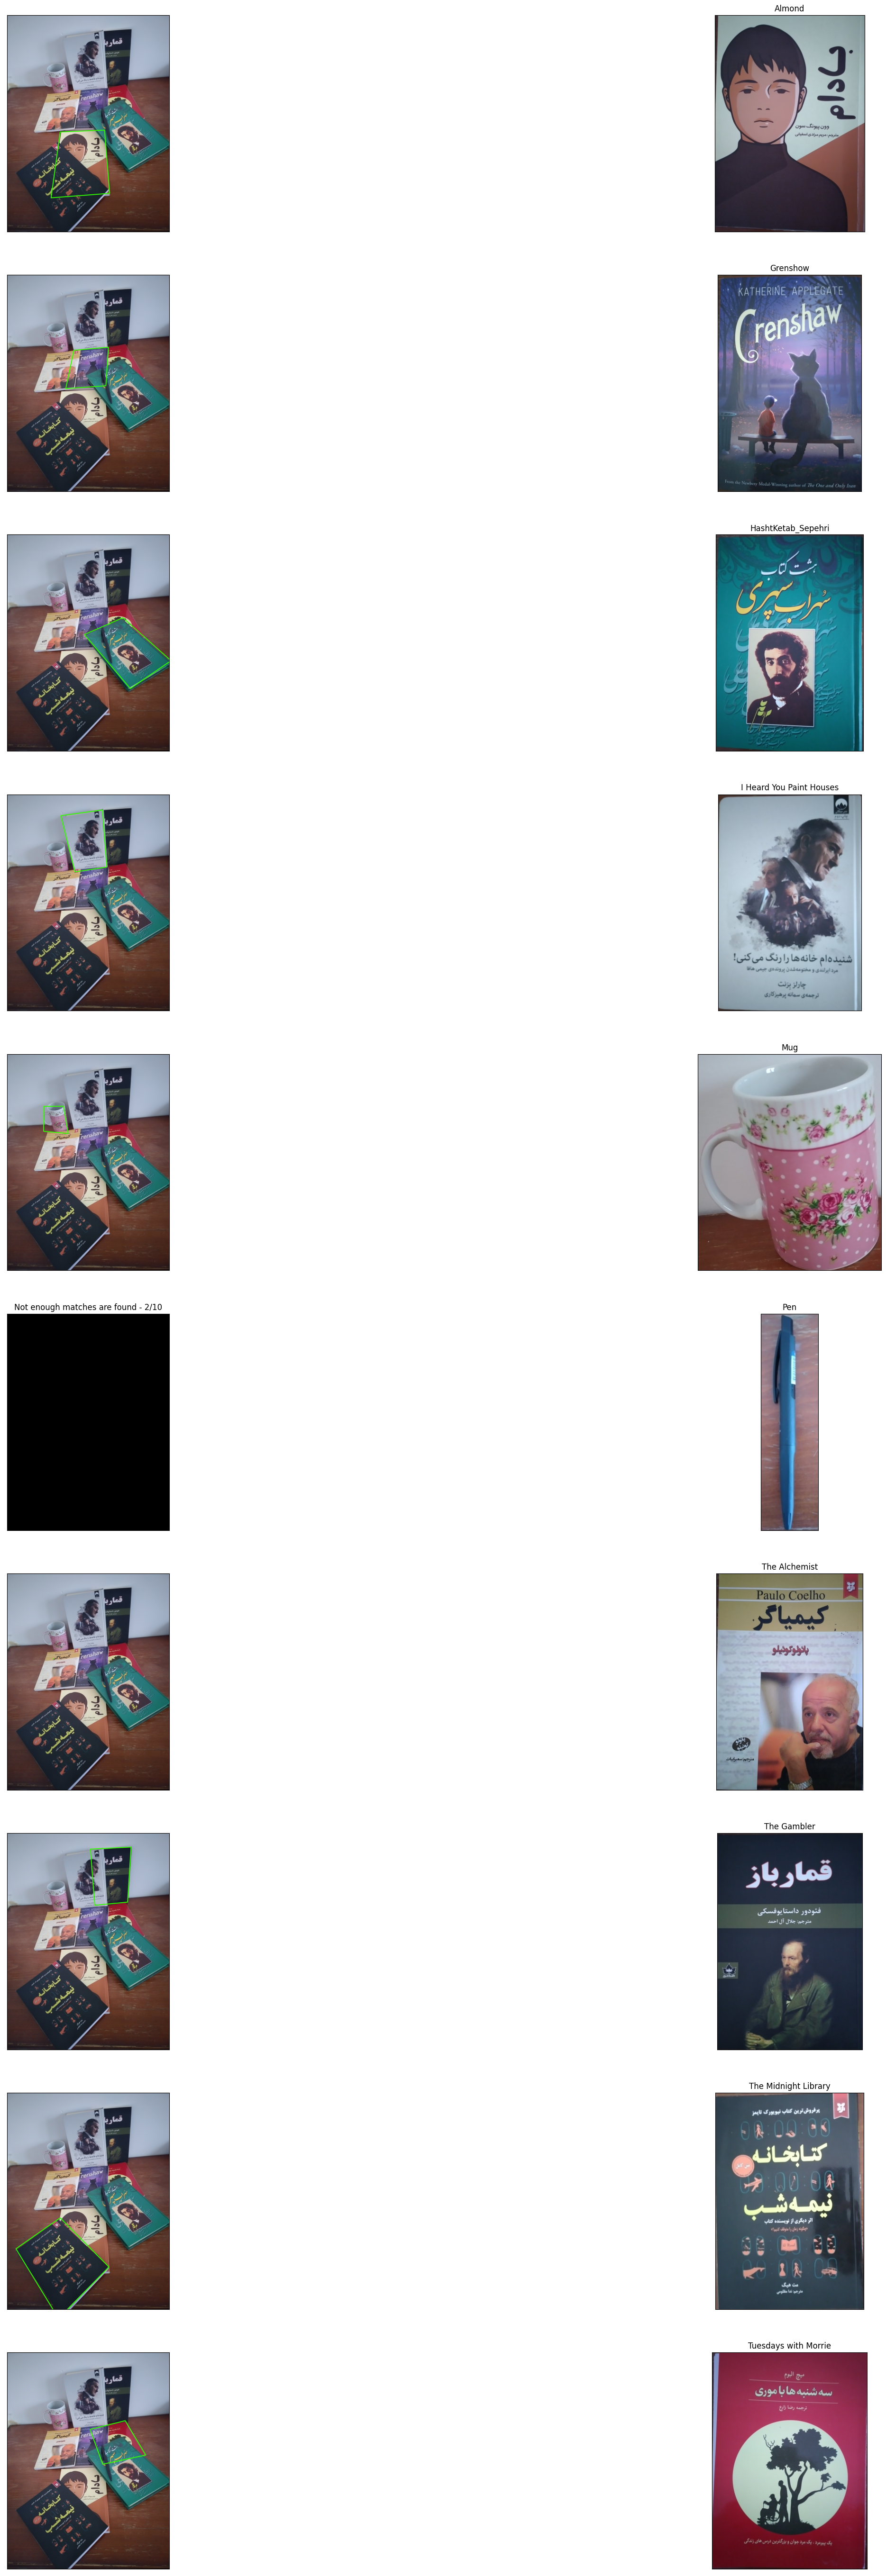

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import re

novels = [novel for novel in glob('media/images/books/*.jpg') if novel!="media/images/books/Novels.jpg"]

rows = len(novels)
plt.figure(figsize=[35,70])

for i,novel_path in enumerate(novels):
    
    novel_img = cv2.imread(novel_path)
    status , result = detector(novel_img)
    
    
    name = re.search(r'[^\\/.]*(?=\.[^.]+$)', novel_path).group()
    # or 
    # name = os.path.splitext(os.path.basename(novel_path))[0]
    k = i*2
        
    plt.subplot(rows,2,k+1)
    plt.imshow(result[...,::-1])
    if status : plt.title(status)
    plt.xticks([]);plt.yticks([])
    
    plt.subplot(rows,2,k+2)
    # novel_img = novel
    plt.imshow(novel_img[...,::-1]);plt.title(name);plt.xticks([]);plt.yticks([])

